In [1]:
#@title Download the German Traffic Signs Dataset
!wget https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
!wget https://raw.githubusercontent.com/AvivSham/German-Traffic-Signs-Classification/master/signnames.csv

--2022-04-02 08:19:16--  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 52.85.90.194, 52.85.90.142, 52.85.90.107, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|52.85.90.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M   146MB/s    in 0.8s    

2022-04-02 08:19:17 (146 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]

--2022-04-02 08:19:17--  https://raw.githubusercontent.com/AvivSham/German-Traffic-Signs-Classification/master/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

In [2]:
!unzip traffic-signs-data.zip

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [29]:
#@title Import dependencies
%matplotlib inline
import os, pickle, shutil
import numpy as np
from skimage.io import imread
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle, compute_class_weight
from sklearn.metrics import confusion_matrix
import csv
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Input, Model

from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from keras.initializers import random_normal
from keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [4]:
# constrain seed
np.random.seed(seed=42)

In [5]:
#@title Moving the data files to directory
!mkdir data
for i in os.listdir():
  if '.p' in i:
    shutil.move('./'+i,'./data')

try:
  shutil.move('./signnames.csv','./data')
except:
  print('No CSV file was found')


In [6]:
#@title Loading Train/Test/Validation data
training_file = './data/train.p'
validation_file = './data/valid.p'
testing_file = './data/test.p'

with open (training_file, mode='rb') as f:
  train = pickle.load(f)
with open (validation_file, mode='rb') as f:
  valid = pickle.load(f)
with open (testing_file, mode='rb') as f:
  test = pickle.load(f)

In [8]:
#@title Read Sign names/classes
signs_classes = []
os.chdir('./data')
with open ('signnames.csv', 'r') as file:
  signnames = csv.reader(file, delimiter = ',')
  next(signnames,None)
  for row in signnames:
    print(row)
    signs_classes.append(row[1])
  file.close()

['0', 'Speed limit (20km/h)']
['1', 'Speed limit (30km/h)']
['2', 'Speed limit (50km/h)']
['3', 'Speed limit (60km/h)']
['4', 'Speed limit (70km/h)']
['5', 'Speed limit (80km/h)']
['6', 'End of speed limit (80km/h)']
['7', 'Speed limit (100km/h)']
['8', 'Speed limit (120km/h)']
['9', 'No passing']
['10', 'No passing for vehicles over 3.5 metric tons']
['11', 'Right-of-way at the next intersection']
['12', 'Priority road']
['13', 'Yield']
['14', 'Stop']
['15', 'No vehicles']
['16', 'Vehicles over 3.5 metric tons prohibited']
['17', 'No entry']
['18', 'General caution']
['19', 'Dangerous curve to the left']
['20', 'Dangerous curve to the right']
['21', 'Double curve']
['22', 'Bumpy road']
['23', 'Slippery road']
['24', 'Road narrows on the right']
['25', 'Road work']
['26', 'Traffic signals']
['27', 'Pedestrians']
['28', 'Children crossing']
['29', 'Bicycles crossing']
['30', 'Beware of ice/snow']
['31', 'Wild animals crossing']
['32', 'End of all speed and passing limits']
['33', 'Turn 

In [9]:
#@title Data info
X_train, Y_train = train['features'], train['labels']
X_valid, Y_valid = valid['features'], valid['labels']
X_test, Y_test = test['features'], test['labels']
n_classes = len(np.unique(Y_train))

print("Number of train samples: ", X_train.shape[0])
print("Number of validation samples: ", X_valid.shape[0])
print("Number of test samples: ", X_test.shape[0])
print("Number of classses: ", n_classes)

Number of train samples:  34799
Number of validation samples:  4410
Number of test samples:  12630
Number of classses:  43


In [10]:
def show_images(data,y_data, label="", cmap=None, n_images = 10):
  plt.figure(figsize = (n_images*2,n_images*2))
  for i in range(n_images):
    plt.subplot(1,n_images,i+1)
    ind = np.random.randint(0,len(data))
    if len(data[ind].shape) == 2:
      cmap = 'gray'
    
    plt.imshow(data[ind],cmap = cmap)
    plt.xlabel(signs_classes[y_data[ind]], fontsize = 8)
    plt.ylabel(label, fontsize = 8)
    plt.xticks([])
    plt.yticks([])
  plt.tight_layout()
  plt.show()

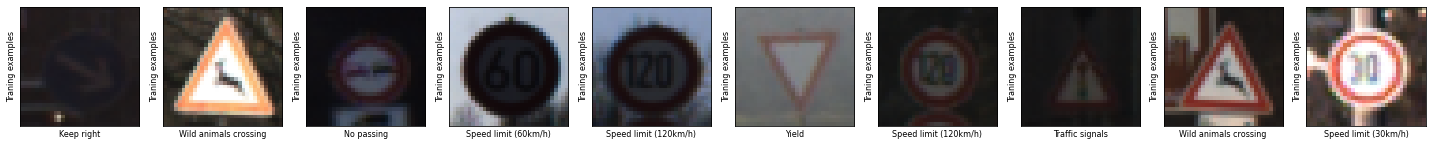

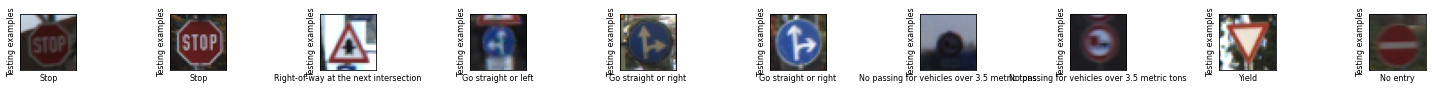

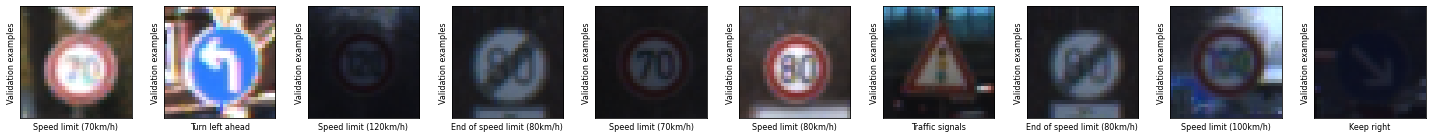

In [11]:
#@title Show samples of each group
show_images(X_train,Y_train,'Traning examples')
show_images(X_test,Y_test,'Testing examples')
show_images(X_valid,Y_valid,'Validation examples')

In [12]:
def show_hist(data, label):
  plt.hist(data, bins = n_classes)
  plt.xlabel(label)
  plt.ylabel('class count')
  plt.grid('off')
  plt.show()

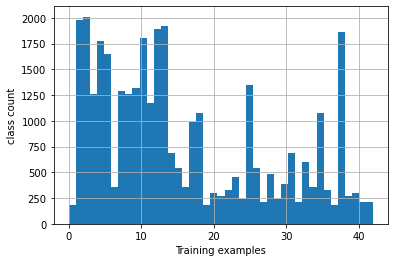

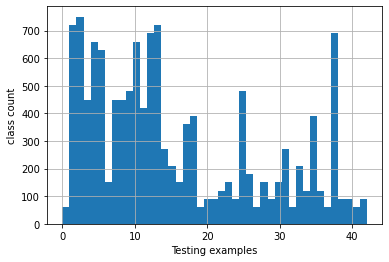

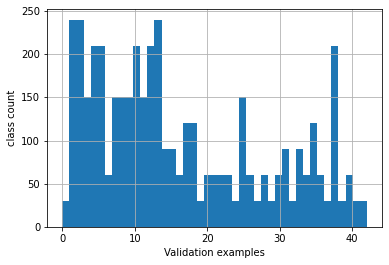

In [13]:
#@title Show groups histogram
show_hist(Y_train, "Training examples")
show_hist(Y_test, "Testing examples")
show_hist(Y_valid, "Validation examples")

In [14]:
X_train, Y_train = shuffle(X_train, Y_train)


In [15]:
def convert_to_gray(image):
  
  return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

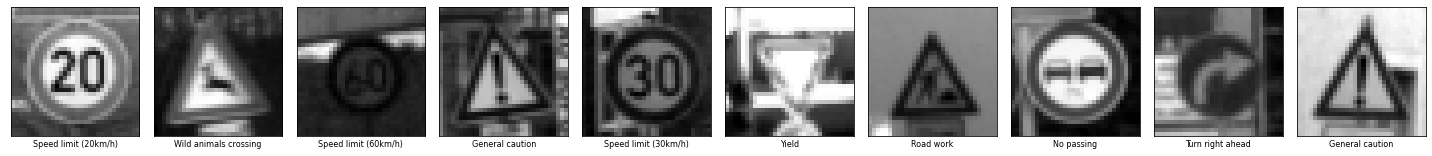

(34799, 32, 32)

In [16]:
#@title Convert to gray scale images 
gray_images = list(map(convert_to_gray,X_train))
show_images(gray_images,Y_train)
np.shape(gray_images)

In [17]:
def hist_equalization(image):
  kernel = morp.disk(30)
  return rank.equalize(image, selem=kernel)
  

In [18]:
def adapt_hist_equalization(image,clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2,2))):
  return clahe.apply(image)

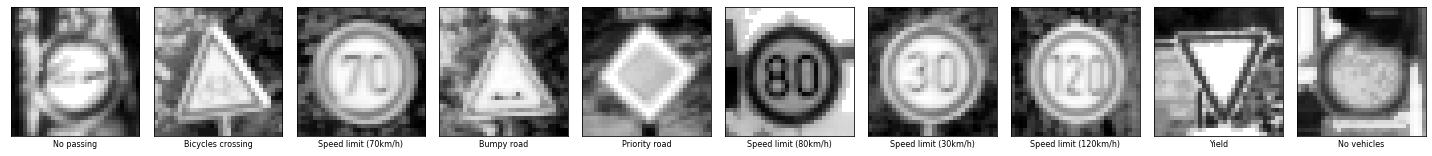

In [19]:
#@title Perform histogram equalization
equalizied_gray_images = list(map(hist_equalization,gray_images))
show_images(equalizied_gray_images,Y_train)

In [20]:
def norm_image(data):
  
  normalized_images = np.array(data,dtype = np.float32)/255
  return np.expand_dims(normalized_images, axis=-1)


In [21]:
def preprocess(x_data,y_data, n_classes = 43):
  gray_images = list(map(convert_to_gray,x_data))
  hist_equal_images = list(map(adapt_hist_equalization,gray_images))
  norm_images = norm_image(hist_equal_images)
  y_data = to_categorical(y_data, n_classes)
  return norm_images, y_data 

In [22]:
def ConvBlock(model, pool, n_filters, mu, sigma):
  model = Conv2D(n_filters, kernel_size = 2, padding = 'same',
                 activation = 'relu', 
                 kernel_initializer = random_normal(mean = mu,stddev = sigma))(model)
  
  model = Conv2D(n_filters, kernel_size = 2, padding = 'same',
                 activation = 'relu', 
                 kernel_initializer = random_normal(mean = mu,stddev = sigma))(model)
  model = MaxPooling2D(pool_size = 2, strides = 2, padding = 'valid')(model)
  model = Dropout(0.5)(model)
  return model
  

In [30]:
def VGG_variation(input_shape,nf=32):
  
  inputs = x = Input(input_shape)
  for i in range(3):
    x = ConvBlock(x,pool = True, n_filters = nf * (i+2), mu = 0, sigma = 0.1)  
  
  x = Flatten()(x)
  for _ in range(2):
    x = Dense(units = 128, activation = 'relu')(x)
  output = Dense(units = 43, activation = 'softmax')(x)
  VGG_var_model = Model(inputs = inputs, outputs = output)
  opti = keras.optimizers.Adam(learning_rate=0.0001)
  VGG_var_model.compile(optimizer = opti, loss = 'categorical_crossentropy',
                       metrics = ['accuracy','categorical_crossentropy'])
  VGG_var_model.summary()
  return VGG_var_model
  
  

In [24]:
class My_Callback(Callback):
    def on_train_begin(self, logs={}):
        print("train begins!")
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        print("-", end='')
        flag_val=True
        if epoch%5==0:
            train_acc = logs.get("acc")
            train_loss = logs.get("loss")
            try:
                val_acc = logs.get("val_acc")
                val_loss = logs.get("val_loss")
            except:
                flag_val=False
            if flag_val:
                print("\n%d"%epoch, "\ttrain_loss: ", train_loss,
                      "\tval_loss: ", val_loss, "\ttrain_acc:", train_acc, 
                      "\tval_acc:", val_acc)
            else:
                print("\n%d"%epoch, "\ttrain_loss: ",
                      train_loss, "\ttrain_acc:", train_acc)    
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10,
                              verbose=1, mode='auto', min_lr=1e-12)
my_callback = My_Callback()

checkpoint = ModelCheckpoint("VGG_GermanSigns_classification.h5", monitor='loss', 
                             verbose=0, save_best_only=True, save_weights_only=True)

In [25]:
#@title Preprocess the data
#X_train_processed, Y_train_cat = preprocess(X_train,Y_train)
#X_valid_processed, Y_valid_cat = preprocess(X_valid, Y_valid)
#class_weights = create_class_weights(Y_train)

NameError: ignored

In [34]:
#@title Create a variation of VGG model
X_train_processed, Y_train_cat = preprocess(X_train,Y_train)
X_valid_processed, Y_valid_cat = preprocess(X_valid, Y_valid)
VGG_model = VGG_variation(X_train_processed.shape[1:])
batch_size = 32
epochs = 25
weights = compute_class_weight('balanced',classes = np.unique(Y_train),y = Y_train)





Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 64)        320       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 64)        16448     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 96)        24672     
                                                           

In [35]:
#@title Training
model_history = VGG_model.fit(X_train_processed, Y_train_cat, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_valid_processed,Y_valid_cat),shuffle=True,
                    callbacks = [my_callback, reduce_lr, checkpoint],verbose=0,)
                    #class_weight = weights)

train begins!
-
0 	train_loss:  3.5022072792053223 	val_loss:  3.5912370681762695 	train_acc: None 	val_acc: None
-----
5 	train_loss:  0.719202995300293 	val_loss:  0.5517234206199646 	train_acc: None 	val_acc: None
-

KeyboardInterrupt: ignored

In [ ]:
#@title Plotting ACC and LOSS of training
# Accuracy
plt.figure(figsize = (8,6))
plt.plot(model_history.history['acc'],'r')
plt.grid('off')
plt.plot(model_history.history['val_acc'],'g')
plt.xticks()
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
plt.show()
# Loss 
plt.figure(figsize = (8,6))
plt.grid('off')
plt.plot(model_history.history['loss'],'r')
plt.plot(model_history.history['val_loss'],'g')
plt.xticks()
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

In [ ]:
#@title Loading best result weights
VGG_model.load_weights("VGG_GermanSigns_classification.h5")

In [ ]:
#@title Preprocessing and predicting the test group
X_test_processed, Y_test_cat = preprocess(X_test, Y_test)
predicted = VGG_model.predict(X_test_processed)
Y_pred = np.argmax(predicted, axis = 1)


In [ ]:
#@title Calculating and presenting the confusion matrix
cm = confusion_matrix(np.argmax(Y_test_cat,axis=1),Y_pred)
plt.figure(figsize = (25,25))
sn.set(font_scale=1)
sn.heatmap(cm, cmap = 'viridis', annot = True, annot_kws = {'size': 8})
plt.show()

In [ ]:
#@title Printing the results
total_accurate = 0
for i in range (cm.shape[0]):
  print('The accuracy of class No.{} is: {:.2f}%' .format(i+1,100*cm[i,i]/cm[i].sum()))
  total_accurate += cm[i,i]
  
print('The total accuracy is: {:.2f}%' .format(100*total_accurate/cm.sum()))
